In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil
import logging

import random
from random import shuffle

import imgaug as ia
import imgaug.augmenters as iaa

logger = tf.get_logger()
logger.setLevel(logging.ERROR)


print("Num GPUS avadible:",len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUS avadible: 1


In [2]:
base_dir=os.path.join( 'data_518')

test1_dir = os.path.join(base_dir, 'test1_leve_fuerte' )
val_dir  = os.path.join(base_dir,'val1_leve_fuerte')

img_height=450
img_width=450
batch_size=32

In [3]:

val_0 = os.path.join(val_dir, 'leve') 
val_1 = os.path.join(val_dir, 'fuerte')

test_0 = os.path.join(test1_dir, 'leve') 
test_1 = os.path.join(test1_dir, 'fuerte')


#numeros
num_0_vl = len(os.listdir(val_0))
num_1_vl = len(os.listdir(val_1))

num_0_t = len(os.listdir(test_0))
num_1_t = len(os.listdir(test_1))


total_val = num_0_vl + num_1_vl
total_test = num_0_t + num_1_t

In [4]:
def rescale_0_to_1(image):
    """
    Rescale image to [0, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    return tf.image.convert_image_dtype(image, tf.float64)

def rescale_min_1_to_1(image):
    """
    Rescale image to [-1, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    # Image must be casted to float32 first.
    image = tf.cast(image, tf.float64)
    # Rescale image from [0, 255] to [0, 2].
    image = tf.multiply(image, 1. / 127.5)
    # Rescale to [-1, 1].
    return tf.subtract(image, 1.0)

In [5]:
image_gen_val = ImageDataGenerator(
    preprocessing_function=rescale_min_1_to_1
)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                   directory=val_dir,
                                                   target_size=(img_height,img_width),
                                                   class_mode='binary'
                                                  )

Found 7646 images belonging to 2 classes.


In [6]:
image_gen_test = ImageDataGenerator(
    preprocessing_function=rescale_min_1_to_1
)

test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                   directory=test1_dir,
                                                   target_size=(img_height,img_width),
                                                   class_mode='binary'
                                                  )

Found 12399 images belonging to 2 classes.


In [7]:
import math  
   
####val####

number_of_examples1 = len(val_data_gen.filenames)
number_of_generator_calls1 = math.ceil(number_of_examples1 / (1.0 * batch_size)) 
# 1.0 above is to skip integer division

val_labels = []

for i in range(0,int(number_of_generator_calls1)):
    val_labels.extend(np.array(val_data_gen[i][1]))
    
    
    
    
####test####
    
number_of_examples2 = len(test_data_gen.filenames)
number_of_generator_calls2 = math.ceil(number_of_examples2 / (1.0 * batch_size)) 
# 1.0 above is to skip integer division

test_labels = []

for i in range(0,int(number_of_generator_calls2)):
    test_labels.extend(np.array(test_data_gen[i][1]))    

In [8]:
model = tf.keras.models.load_model('modelos//prueban450x450_2.h5')

In [9]:
'''model = tf.keras.models.Sequential([
    tf.keras.applications.InceptionV3(include_top=False,  weights="imagenet", input_shape=(img_height,img_width,3), pooling='avg'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.load_weights('weights//peso450x450.best.hdf5') '''   
    



'model = tf.keras.models.Sequential([\n    tf.keras.applications.InceptionV3(include_top=False,  weights="imagenet", input_shape=(img_height,img_width,3), pooling=\'avg\'),\n    tf.keras.layers.Dense(1,activation=\'sigmoid\')\n])\nmodel.load_weights(\'weights//peso450x450.best.hdf5\') '

In [10]:


y_pred1 =  model.predict(val_data_gen, steps= int(np.ceil(total_val / float(batch_size))))

y_pred2 =  model.predict(test_data_gen, steps= int(np.ceil(total_test / float(batch_size))))



In [11]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr1 , tpr1 , thresholds1 = roc_curve ( val_labels , y_pred1)

fpr2 , tpr2 , thresholds2 = roc_curve ( test_labels , y_pred2)



In [12]:
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  


In [13]:
def tpr_to_umbrales(tpr,fpr,thresholds,lista):
    umbrales=[]
    fprumb=[]
    
    for i in lista:
        umbrales.append(thresholds[(np.where(tpr>=i))[0][0]])
        fprumb.append(fpr[(np.where(tpr>=i))[0][0]])
    
    return (umbrales, fprumb)

In [14]:
def umbral_mejor(tpr,fpr,thresholds):
    distancias=(1-tpr)+fpr
    
    umbral=thresholds[(np.where(distancias==min(distancias)))[0][0]]
    tpr1=tpr[(np.where(distancias==min(distancias)))[0][0]]
    fpr1=fpr[(np.where(distancias==min(distancias)))[0][0]]
    
    return (umbral,tpr1,fpr1)

Evaluación Validación


In [15]:
roc_auc_score(val_labels, y_pred1)

0.907390065540578

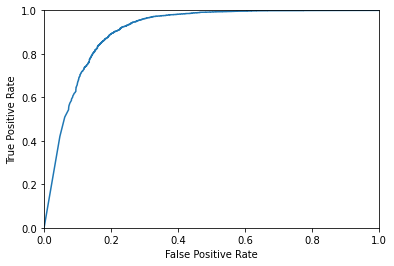

In [16]:
plot_roc_curve (fpr1,tpr1)

In [17]:
lista=[0.98,0.95,0.90,0.80]
  

umbrales , fprumb =tpr_to_umbrales(tpr1,fpr1,thresholds1,lista)

for idx,i in enumerate(lista):
    print("tpr:"+str(i)+"->fpr: "+str(fprumb[idx])+" con umbral: "+str(umbrales[idx]))

tpr:0.98->fpr: 0.3814713896457766 con umbral: 0.00023166389
tpr:0.95->fpr: 0.27520435967302453 con umbral: 0.3036237
tpr:0.9->fpr: 0.20935513169845596 con umbral: 0.9839294
tpr:0.8->fpr: 0.14532243415077203 con umbral: 0.9998447


In [18]:
umbral_1,tpr_1,fpr_1=umbral_mejor(tpr1,fpr1,thresholds1)

print("tpr:"+str(tpr_1)+"->fpr: "+str(fpr_1)+" con umbral: "+str(umbral_1))

tpr:0.8938280675973549->fpr: 0.20118074477747502 con umbral: 0.9894964


Evaluación test 


In [19]:
roc_auc_score(test_labels, y_pred2)

0.9145593308903326

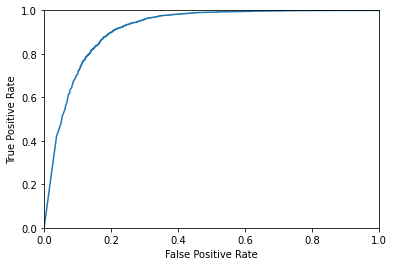

In [20]:
plot_roc_curve (fpr2,tpr2)

In [21]:

umbrales , fprumb =tpr_to_umbrales(tpr2,fpr2,thresholds2,lista)

for idx,i in enumerate(lista):
    print("tpr:"+str(i)+"->fpr: "+str(fprumb[idx])+" con umbral: "+str(umbrales[idx]))

tpr:0.98->fpr: 0.37996469549867606 con umbral: 0.00011045791
tpr:0.95->fpr: 0.2828773168578994 con umbral: 0.2572386
tpr:0.9->fpr: 0.2003530450132392 con umbral: 0.9872224
tpr:0.8->fpr: 0.13459841129744043 con umbral: 0.99984777


In [22]:
umbral_2,tpr_2,fpr_2=umbral_mejor(tpr2,fpr2,thresholds2)

print("tpr:"+str(tpr_2)+"->fpr: "+str(fpr_2)+" con umbral: "+str(umbral_2))

tpr:0.9092075397217013->fpr: 0.2082965578111209 con umbral: 0.97731733
